In [11]:
import numpy as np
import matplotlib.pyplot as plt
from svmsource import *
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA

scaler = StandardScaler()

%matplotlib notebook
plt.style.use('ggplot')

## SVM on iris dataset

### 1. Classification 1 vs 2 with a linear kernel

In [12]:
# Take a look at the data: 
# http://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
# https://fr.wikipedia.org/wiki/Iris_%28jeu_de_donn%C3%A9es%29

iris = datasets.load_iris()
X = iris.data
X = scaler.fit_transform(X)

y = iris.target  # 3 classes: (Setosa, Versicolour, and Virginica)
X = X[y != 0, :2]
y = y[y != 0]

clf_linear = SVC(C=1, kernel="linear")
clf_linear.fit(X, y)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

### 2. Compare linear kernel with the polynomial one

In [13]:
X, y = shuffle(X, y)
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

###############################################################################
# Fit the model with linear vs polynomial kernel
###############################################################################

# Different kernels and their parameters
# http://scikit-learn.org/stable/modules/svm.html#svm-kernels

parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
svr = SVC()
clf_linear = GridSearchCV(svr, parameters)
clf_linear.fit(X_train, y_train)
clf_linear.score(X_test, y_test)

print("Generalization score for linear kernel: %s, %s" %
      (clf_linear.score(X_train, y_train),
       clf_linear.score(X_test, y_test)))

Cs = list(np.logspace(-3, 3, 5))
gammas = 10. ** np.arange(1, 2)
degrees = np.r_[2, 3]
parameters = {'kernel': ['poly'], 'C': Cs, 'gamma': gammas, 'degree': degrees}

svr = SVC()
clf_poly = GridSearchCV(svr, parameters)
clf_poly.fit(X_train, y_train)
clf_poly.score(X_test, y_test)
clf_poly.best_params_
print("Generalization score for polynomial kernel: %s, %s" %
      (clf_poly.score(X_train, y_train),
       clf_poly.score(X_test, y_test)))

plt.figure(figsize=(12, 5))
plt.subplot(131)
plot_2d(X, y)
plt.title("iris dataset")

plt.subplot(132)
plot_2d(X, y)
frontiere(clf_linear.predict, X, y)
plt.title("linear kernel")

plt.subplot(133)
plot_2d(X, y)
frontiere(clf_poly.predict, X, y)
plt.title("polynomial kernel")
plt.tight_layout()
plt.show()

/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Generalization score for linear kernel: 0.7066666666666667, 0.8
Generalization score for polynomial kernel: 0.64, 0.6


/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


<IPython.core.display.Javascript object>

## SVM GUI

Please open a terminal and run python svm_gui.py
Then, play with the applet : generate various datasets and observe the
different classifiers you can obtain by varying the kernel

## Face classification

Import the lfw data

In [14]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""
####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# Introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

ImportError: The Python Imaging Library (PIL) is required to load data from jpeg files

Pick two people

In [5]:
# The label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

### 5. Extract features and center-normalize features

In [6]:
# Features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

### 6. Study influence of the regularization parameter

Fitting the classifier to the training set
Best C: 0.001


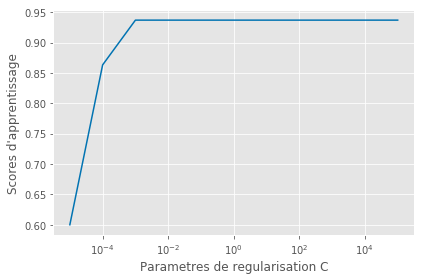

Best score: 0.9368421052631579


In [7]:
####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

Cs = 10. ** np.arange(-5, 6)
scores = []
for C in Cs:
    clf = SVC(kernel="linear", C=C)
    clf.fit(X_train, y_train)
    scores += [clf.score(X_test, y_test)]
ind = np.argmax(scores)
print("Best C: {}".format(Cs[ind]))
plt.figure()
plt.plot(Cs, scores)
plt.xlabel("Parametres de regularisation C")
plt.ylabel("Scores d'apprentissage")
plt.xscale("log")
plt.tight_layout()
plt.show()
print("Best score: {}".format(np.max(scores)))

Predict using the best parameter value

In [8]:
print("Predicting the people names on the testing set")
t0 = time()

# Predict labels for the X_test images
clf = SVC(kernel="linear", C=Cs[np.argmax(scores)])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

Predicting the people names on the testing set
done in 0.553s
Chance level : 0.6210526315789474
Accuracy : 0.9368421052631579


Qualitative evaluation of the predictions using matplotlib

Qualitative evaluation of the predictions


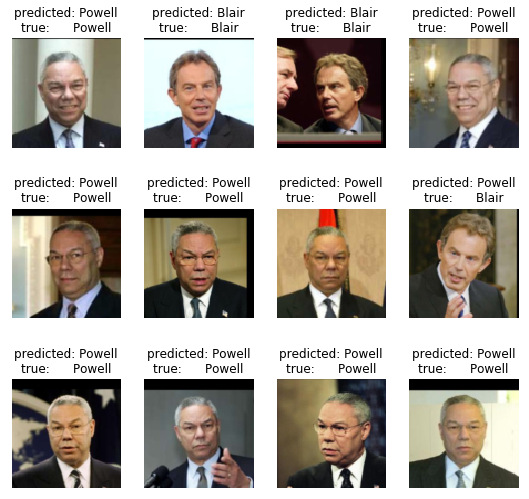

In [9]:
print("Qualitative evaluation of the predictions")
prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

### 7. Noise variables

Function for obtaining the score (with CV inside)

In [22]:
def run_svm_cv(X, y):
    
    indices = np.random.permutation(X.shape[0])
    train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
    X_train, X_test = X[train_idx, :], X[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]

    parameters = {'kernel': ['linear'], 'C': list(np.logspace(-3, 3, 5))}
    svr = SVC()
    clf_linear = GridSearchCV(svr, parameters)
    clf_linear.fit(X_train, y_train)

    print("Generalization score for linear kernel: %s, %s \n" %
          (clf_linear.score(X_train, y_train), clf_linear.score(X_test, y_test)))

Obtain scores with and without noise

In [23]:
print("Score sans variable de nuisance")
run_svm_cv(X, y)

print("Score avec variable de nuisance")
n_features = X.shape[1]
# Add the noising variables
sigma = 1
noise = sigma * np.random.randn(n_samples, 300, )
X_noisy = np.concatenate((X, noise), axis=1)
X_noisy = X_noisy[np.random.permutation(X.shape[0])]
run_svm_cv(X_noisy, y)

Score sans variable de nuisance
Generalization score for linear kernel: 0.66, 0.72 

Score avec variable de nuisance


/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/b/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


NameError: name 'n_samples' is not defined

### 8. Dimension reduction using PCA

In [12]:
print("Score apres reduction de dimension")

n_components = 100  # try/change the number of components
pca = PCA(n_components=n_components).fit(X_noisy)
X_noisy_pca = pca.transform(X_noisy)
run_svm_cv(X_noisy_pca, y)

Score apres reduction de dimension
Generalization score for linear kernel: 0.8263157894736842, 0.5105263157894737 



### 10. Primal and dual

In [13]:
# Primal/dual
C = 0.01
y = 2 * y - 1  # Pour avoir des classes 1 et -1

def primal_dual(tol):
    
    clf = SVC(kernel='linear', C=C, tol=tol)
    clf.fit(X, y)
    loss = 1 - y * clf.decision_function(X)
    primal = 0.5 * np.linalg.norm(clf.coef_) ** 2 + C * np.sum(loss[loss > 0])

    # Linear kernel
    K = np.dot(X[clf.support_], X[clf.support_].T)
    dual_coef = clf.dual_coef_.ravel()  # dual_coef_ return a vector of y_i * alpha_i
    dual = np.linalg.norm(dual_coef, ord=1) - 0.5 * np.dot(dual_coef, np.dot(K, dual_coef))

    return primal, dual, primal - dual

Evaluate and plot the graph

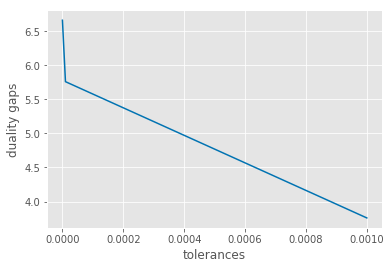

In [14]:
tols = 10. ** (-np.arange(3, 16, 2))
dual_gaps = [primal_dual(tol)[2] for tol in tols]
plt.figure()
plt.plot(tols, -np.log10(dual_gaps))
plt.ylabel("duality gaps")
plt.xlabel("tolerances")
plt.show()